In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591

from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
test_cands  = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()


In [2]:
from util import load_external_labels

#%time load_external_labels(session, Spouse, annotator_name='gold')

from snorkel.annotations import load_gold_labels

#L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [3]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

gold_labels_dev = []
for i,L in enumerate(L_gold_dev):
    gold_labels_dev.append(L[0,0])
    
gold_labels_test = []
for i,L in enumerate(L_gold_test):
    gold_labels_test.append(L[0,0])
    
print(len(gold_labels_dev),len(gold_labels_test))
print(gold_labels_dev.count(1),gold_labels_dev.count(-1))

(2796, 2697)
(196, 2600)


In [4]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


In [13]:
##### Continuous ################

softmax_Threshold = 0.3
LF_Threshold = 0.3

import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)


spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for sw in spouses:
        sc=max(sc,get_similarity(word_vectors,sw))
    return (1,sc)

def LF_husband_wife_left_window(c):
    global LF_Threshold
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for sw in spouses:
        sc_1=max(sc_1,get_similarity(word_vectors,sw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for sw in spouses:
        sc_2=max(sc_2,get_similarity(word_vectors,sw))
    return(1,max(sc_1,sc_2))
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return (1,1)
    return (0,0)

def LF_no_spouse_in_sentence(c):
    return (-1,0.75) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

def LF_and_married(c):
    global LF_Threshold
    word_vectors = get_word_vectors(preprocess(get_right_tokens(c)))
    sc = get_similarity(word_vectors,'married')
    
    if 'and' in get_between_tokens(c):
        return (1,sc)
    else:
        return (0,0)

def LF_familial_relationship(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for fw in family:
        sc=max(sc,get_similarity(word_vectors,fw))
        
    return (-1,sc) 

def LF_family_left_window(c):
    global LF_Threshold
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for fw in family:
        sc_1=max(sc_1,get_similarity(word_vectors,fw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for fw in family:
        sc_2=max(sc_2,get_similarity(word_vectors,fw))
        
    return (-1,max(sc_1,sc_2))

def LF_other_relationship(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
        
    return (-1,sc) 

def LF_other_relationship_left_window(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
    return (-1,sc) 

import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,1)

import numpy as np

def LF_Three_Lists_Left_Window(c):
    global softmax_Threshold
    c1,s1 = LF_husband_wife_left_window(c)
    c2,s2 = LF_family_left_window(c)
    c3,s3 = LF_other_relationship_left_window(c)
    sc = np.array([s1,s2,s3])
    c = [c1,c2,c3]
    sharp_param = 1.5
    prob_sc = np.exp(sc * sharp_param - np.max(sc))
    prob_sc = prob_sc / np.sum(prob_sc)
    #print 'Left:',s1,s2,s3,prob_sc
    
    if s1==s2 or s3==s1:
        return (0,0)
    return c[np.argmax(prob_sc)],1

def LF_Three_Lists_Between_Words(c):
    global softmax_Threshold
    c1,s1 = LF_husband_wife(c)
    c2,s2 = LF_familial_relationship(c)
    c3,s3 = LF_other_relationship(c)
    sc = np.array([s1,s2,s3])
    c = [c1,c2,c3]
    sharp_param = 1.5
    
    prob_sc = np.exp(sc * sharp_param - np.max(sc))
    prob_sc = prob_sc / np.sum(prob_sc)
    #print 'BW:',s1,s2,s3,prob_sc
    if s1==s2 or s3==s1:
        return (0,0)
    return c[np.argmax(prob_sc)],1
    
LFs = [LF_distant_supervision, LF_distant_supervision_last_names,LF_same_last_name,
       LF_and_married, LF_Three_Lists_Between_Words,LF_Three_Lists_Left_Window, LF_no_spouse_in_sentence
      ]

In [7]:

import numpy as np
import math

def PHI(K,LAMDAi,SCOREi):
    return [K*l*s for (l,s) in zip(LAMDAi,SCOREi)]

def softmax(THETA,LAMDAi,SCOREi):
    x = []
    for k in [1,-1]:
        product = np.dot(PHI(k,LAMDAi,SCOREi),THETA)
        x.append(product)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def function_conf(THETA,LAMDA,P_cap,Confidence):
    s = 0.0
    i = 0
    for LAMDAi in LAMDA:
        s = s + Confidence[i]*np.dot(np.log(softmax(THETA,LAMDAi)),P_cap[i])
        i = i+1
    return -s

def function(THETA,LAMDA,SCORE,P_cap):
    s = 0.0
    i = 0
    for i in range(len(LAMDA)):
        s = s + np.dot(np.log(softmax(THETA,LAMDA[i],SCORE[i])),P_cap[i])
        i = i+1
    return -s

def P_K_Given_LAMDAi_THETA(K,THETA,LAMDAi,SCOREi):
    x = softmax(THETA,LAMDAi,SCOREi)
    if(K==1):
        return x[0]
    else:
        return x[1]
      

np.random.seed(78)
THETA = np.random.rand(len(LFs),1)

def PHIj(j,K,LAMDAi,SCOREi):
    return LAMDAi[j]*K*SCOREi[j]

def RIGHT(j,LAMDAi,SCOREi,THETA):
    phi = []
    for k in [1,-1]:
        phi.append(PHIj(j,k,LAMDAi,SCOREi))
    x = softmax(THETA,LAMDAi,SCOREi)
    return np.dot(phi,x)
    

def function_conf_der(THETA,LAMDA,P_cap,Confidence):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for LAMDAi in LAMDA:
            p = 0
            for K in [1,-1]:
                s = s + Confidence[i]*(PHIj(j,K,LAMDAi)-RIGHT(j,LAMDAi,THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)

def function_der(THETA,LAMDA,SCORE,P_cap):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for index in range(len(LAMDA)):
            p = 0
            for K in [1,-1]:
                s = s + (PHIj(j,K,LAMDA[index],SCORE[index])-RIGHT(j,LAMDA[index],SCORE[index],THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)


import numpy as np


def get_LAMDA(cands):
    LAMDA = []
    SCORE = []
    for ci in cands:
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        LAMDA.append(L)
        SCORE.append(S) 
    return LAMDA,SCORE

def get_Confidence(LAMDA):
    confidence = []
    for L in LAMDA:
        Total_L = float(len(L))
        No_zeros = L.count(0)
        No_Non_Zeros = Total_L - No_zeros
        confidence.append(No_Non_Zeros/Total_L)
    return confidence    
    
def get_Initial_P_cap(LAMDA):
    P_cap = []
    for L in LAMDA:
        P_ik = []
        denominator=float(L.count(1)+L.count(-1))
        if(denominator==0):
            denominator=1
        P_ik.append(L.count(1)/denominator)
        P_ik.append(L.count(-1)/denominator)
        P_cap.append(P_ik)
    return P_cap
    #print(np.array(LAMDA))
    #print(np.array(P_cap))append(L)
    #LAMDA=np.array(LAMDA).astype(int)
    #P_cap=np.array(P_cap)
    #print(np.array(LAMDA).shape)
    #print(np.array(P_cap).shape)
    #print(L)
    #print(ci.chemical.get_span(),ci.disease.get_span(),"No.Os",L.count(0),"No.1s",L.count(1),"No.-1s",L.count(-1))
    #print(ci.chemical.get_span(),ci.disease.get_span(),"P(0):",L.count(0)/len(L)," P(1)",L.count(1)/len(L),"P(-1)",L.count(-1)/len(L))

        
def get_P_cap(LAMDA,SCORE,THETA):
    P_cap = []
    for i in range(len(LAMDA)):
        P_capi = softmax(THETA,LAMDA[i],SCORE[i])
        P_cap.append(P_capi)
    return P_cap


def score(predicted_labels,gold_labels):
    tp =0.0
    tn =0.0
    fp =0.0
    fn =0.0
    for i in range(len(gold_labels)):
        if(predicted_labels[i]==gold_labels[i]):
            if(predicted_labels[i]==1):
                tp=tp+1
            else:
                tn=tn+1
        else:
            if(predicted_labels[i]==1):
                fp=fp+1
            else:
                fn=fn+1
    print("tp",tp,"tn",tn,"fp",fp,"fn",fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1score = (2*precision*recall)/(precision+recall)
    print("precision:",precision)
    print("recall:",recall)
    print("F1 score:",f1score)
                
           
    
from scipy.optimize import minimize
import cPickle as pickle

def get_marginals(P_cap):
    marginals = []
    for P_capi in P_cap:
        marginals.append(P_capi[0])
    return marginals

def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels

def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    plt.bar(range(0,2796),marginals)
    plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
    
    
def train(No_Iter,Use_Confidence=True,theta_file_name="THETA"):
    global THETA
    global dev_LAMDA,dev_SCORE
    LAMDA,SCORE = get_LAMDA(train_cands)
    P_cap = get_Initial_P_cap(LAMDA)
    Confidence = get_Confidence(LAMDA)
    for iteration in range(No_Iter):
        if(Use_Confidence==True):
            res = minimize(function_conf,THETA,args=(LAMDA,P_cap,Confidence), method='BFGS',jac=function_conf_der,options={'disp': True, 'maxiter':20}) #nelder-mead
        else:
            res = minimize(function,THETA,args=(LAMDA,SCORE,P_cap), method='BFGS',jac=function_der,options={'disp': True, 'maxiter':20}) #nelder-mead            
        THETA = res.x # new THETA
        print(THETA)
        P_cap = get_P_cap(LAMDA,SCORE,THETA) #new p_cap 
        print_details("train iteration: "+str(iteration),THETA,dev_LAMDA,dev_SCORE)
        #score(predicted_labels,gold_labels)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Train_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Train_P_cap.p","wb"))
    NP_THETA = np.array(THETA)
    np.savetxt(theta_file_name+'.txt', NP_THETA, fmt='%f') 
    pickle.dump( NP_THETA, open( theta_file_name+'.p', "wb" )) # save the file as "outfile_name.npy" 

        
def test(THETA):
    global dev_LAMDA,dev_SCORE
    P_cap = get_P_cap(dev_LAMDA,dev_SCORE,THETA)
    print_details("test:",THETA,dev_LAMDA,dev_SCORE)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Dev_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Dev_P_cap.p","wb"))
                    
def load_marginals(s):
    marginals = []
    if(s=="train"):
        train_P_cap = np.load("Train_P_cap.npy")
        marginals = train_P_cap[:,0]
    return marginals



NameError: name 'LFs' is not defined

In [6]:
''' output:

    [[[L_x1],[S_x1]],
     [[L_x2],[S_x2]],
     ......
     ......
    ]

'''
def get_L_S_Tensor(cands): 
    
    L_S = []
    for ci in cands:
        L_S_ci=[]
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        L_S_ci.append(L)
        L_S_ci.append(S)
        L_S.append(L_S_ci) 
    return L_S

def get_L_S(cands):  # sign gives label abs value gives score
    
    L_S = []
    for ci in cands:
        l_s=[]
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            s= (s+1)/2  #to scale scores in [0,1] 
            l_s.append(l*s)
        L_S.append(l_s)
    return L_S

def get_Initial_P_cap_L_S(L_S):
    P_cap = []
    for L,S in L_S:
        P_ik = []
        denominator=float(L.count(1)+L.count(-1))
        if(denominator==0):
            denominator=1
        P_ik.append(L.count(1)/denominator)
        P_ik.append(L.count(-1)/denominator)
        P_cap.append(P_ik)
    return P_cap



In [31]:
# import matplotlib.pyplot as plt
   
    
# dev_L_S = get_L_S_Tensor(dev_cands)
# train_L_S = get_L_S_Tensor(train_cands)
# test_L_S = get_L_S_Tensor(test_cands)


# train_P_cap= get_Initial_P_cap_L_S(train_L_S) 

# dev_P_cap = get_Initial_P_cap_L_S(dev_L_S)

# test_P_cap = get_Initial_P_cap_L_S(test_L_S)

# import cPickle as pkl

# pkl.dump(dev_L_S,open("dev_L_S.p","wb"))
# pkl.dump(train_L_S,open("train_L_S.p","wb"))
# pkl.dump(test_L_S,open("test_L_S.p","wb"))

# pkl.dump(train_P_cap,open("train_P_cap.p","wb"))
# pkl.dump(dev_P_cap,open("dev_P_cap.p","wb"))
# pkl.dump(test_P_cap,open("test_P_cap.p","wb"))

In [89]:
#prepare batch data
train_L_S_batch,dev_L_S_batch = get_L_S_batch()
train_P_cap_batch,dev_P_cap_batch = get_P_cap_batch()

In [11]:
from sklearn.metrics import precision_recall_fscore_support

import cPickle as pkl


#pkl.dump(dev_L_S,open("dev_L_S.p","wb"))
#pkl.dump(train_L_S,open("train_L_S.p","wb"))
#pkl.dump(test_L_S,open("test_L_S.p","wb"))

#pkl.dump(train_P_cap,open("train_P_cap.p","wb"))
#pkl.dump(dev_P_cap,open("dev_P_cap.p","wb"))
#pkl.dump(test_P_cap,open("test_P_cap.p","wb"))

dev_L_S = pkl.load( open( "dev_L_S.p", "rb" ) )
train_L_S = pkl.load( open( "train_L_S.p", "rb" ) )
test_L_S = pkl.load( open( "test_L_S.p", "rb" ) )

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )
test_P_cap = pkl.load( open( "test_P_cap.p", "rb" ) )

def get_L_S_batch():
    dev_L_batch = []
    dev_S_batch = []
    dev_L_S_batch = []
    train_L_batch = []
    train_S_batch = []
    train_L_S_batch = []
    for l,s in train_L_S:
        train_L_batch.append(l)
        train_S_batch.append(s)
    train_L_S_batch = [train_L_batch, train_S_batch]
    for l,s in dev_L_S:
        dev_L_batch.append(l)
        dev_S_batch.append(s)
    dev_L_S_batch = [dev_L_batch, dev_S_batch]
    return train_L_S_batch,dev_L_S_batch


def get_P_cap_batch():
    kp1_train= []
    kn1_train = []
    kp1_dev= []
    kn1_dev = []
    for pci in train_P_cap:
        kp1_train.append(pci[0])
        kn1_train.append(pci[1])
    for pci in dev_P_cap:
        kp1_dev.append(pci[0])
        kn1_dev.append(pci[1])
    return [kp1_train,kn1_train],[kp1_dev,kn1_dev]
        
def get_mini_batches(X,P_cap,bsize): #X : (train/dev/)_L_S_batch
    for i in range(0, len(X[0]) - bsize + 1, bsize):
        indices = slice(i, i + bsize)
        #print(indices)
        yield [X[0][indices],X[1][indices]],P_cap[indices]

train_L_S_batch,dev_L_S_batch = get_L_S_batch()

#for x in get_mini_batches(train_L_S_batch,200):
#    print(len(x),len(x[0]),len(x[0][0]))
    


In [137]:
#stochastic + cross entropy logits func + remove min(theta,0) in loss
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )


dim = 2 #(labels,scores)

_x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(2))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])

#for k = 1

k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

k_n1 = tf.negative(k_p1)


l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

phi_out = tf.stack([phi_p1,phi_n1])

# loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
#         tf.reduce_sum(tf.multiply(alphas,alphas)) + \
#         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
#         - tf.minimum( tf.reduce_min(thetas),0)

loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=phi_out,labels=_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas))\
        + tf.reduce_sum(tf.multiply(thetas,thetas)) 
        #- tf.minimum( tf.reduce_min(thetas),0)
         

predict = tf.argmax(tf.nn.softmax(phi_out))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
'''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
        _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        print(_los)
        print(_l)
        print(_s)
        print(_a)
        print(_os)        
        print(_t)
        print()'''
    
for i in range(10):
    c = 0
    te_prev=1
    total_te = 0
    for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
        
        a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        total_te+=te_curr
        #print(a)
        #print(t)
        #print
        New_P_cap = []
        newPcap = sess.run(new_p_cap,feed_dict={_x:train_L_S[c+1],_p_cap:train_P_cap[c+1]})
        train_P_cap[c+1] = newPcap
#         for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
#             newPcap = sess.run(new_p_cap,feed_dict={_x:L_S_i,_p_cap:P_cap_i})
#             New_P_cap.append(newPcap)
#         train_P_cap = New_P_cap

        
        if(abs(te_curr-te_prev)<1e-300):
            predicted_labels = []
            for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                predicted_labels.append(p)
            print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
            break
        
#         if(c%20==0):
#             predicted_labels = []
#             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
#                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
#                 predicted_labels.append(p)
#             print(predicted_labels.count(0),predicted_labels.count(1))
#             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
#         c+=1
        te_prev = te_curr
    
    pl = []
    for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
        te_curr,p = sess.run([loss,predict],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        pl.append(p)
    predicted_labels = [-1 if x==0 else x for x in pl]
    print(total_te)
    print(predicted_labels.count(1),predicted_labels.count(-1))
    print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
      
    


0   (0.16216216216216217, 0.61224489795918369, 0.25641025641025639, None)
-3.05101543903e+24
781 2015
0   (0.15492957746478872, 0.61734693877551017, 0.24769703172978502, None)
0   (0.16216216216216217, 0.61224489795918369, 0.25641025641025639, None)
-1.49612942222e+82
781 2015
0   (0.15492957746478872, 0.61734693877551017, 0.24769703172978502, None)
0   (0.16216216216216217, 0.61224489795918369, 0.25641025641025639, None)
-9.57592297318e+139
781 2015
0   (0.15492957746478872, 0.61734693877551017, 0.24769703172978502, None)
0   (0.16216216216216217, 0.61224489795918369, 0.25641025641025639, None)
-6.12903532452e+197
781 2015
0   (0.15492957746478872, 0.61734693877551017, 0.24769703172978502, None)
0   (0.17638266068759342, 0.60204081632653061, 0.27283236994219651, None)
-3.92286718621e+255
0 2796
0   (0.0, 0.0, 0.0, None)
nan
0 2796
0   (0.0, 0.0, 0.0, None)
nan
0 2796
0   (0.0, 0.0, 0.0, None)
nan
0 2796
0   (0.0, 0.0, 0.0, None)
nan
0 2796
0   (0.0, 0.0, 0.0, None)
nan
0 2796
0   (0.0

In [9]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

def class_wise(y_test,y_score):
    print(average_precision_score(y_test, y_score, average=None))
    
def draw_curve(y_test,y_score):
    average_precision = average_precision_score(y_test, y_score)

    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
              average_precision))

0 -3.05101543903e+24
737 2059
(0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)


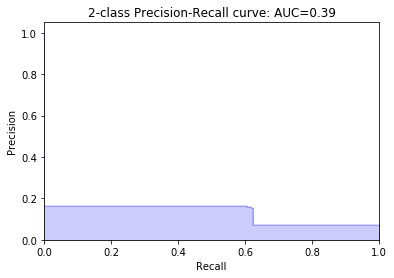

In [24]:
#stochastic + cross entropy logits func + remove min(theta,0) in loss + precision recall curve
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )


dim = 2 #(labels,scores)

_x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(2))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])

#for k = 1

k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

k_n1 = tf.negative(k_p1)


l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

phi_out = tf.stack([phi_p1,phi_n1])

# loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
#         tf.reduce_sum(tf.multiply(alphas,alphas)) + \
#         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
#         - tf.minimum( tf.reduce_min(thetas),0)

loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=phi_out,labels=_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas))\
        + tf.reduce_sum(tf.multiply(thetas,thetas)) 
        #- tf.minimum( tf.reduce_min(thetas),0)
         

predict = tf.argmax(tf.nn.softmax(phi_out))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
'''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
        _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        print(_los)
        print(_l)
        print(_s)
        print(_a)
        print(_os)        
        print(_t)
        print()'''
    
for i in range(10):
    c = 0
    te_prev=1
    total_te = 0
    for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
        
        a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        total_te+=te_curr
        #print(a)
        #print(t)
        #print
        New_P_cap = []
        newPcap = sess.run(new_p_cap,feed_dict={_x:train_L_S[c+1],_p_cap:train_P_cap[c+1]})
        train_P_cap[c+1] = newPcap
#         for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
#             newPcap = sess.run(new_p_cap,feed_dict={_x:L_S_i,_p_cap:P_cap_i})
#             New_P_cap.append(newPcap)
#         train_P_cap = New_P_cap

        
        if(abs(te_curr-te_prev)<1e-300):
            break
            predicted_labels = []
            for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                predicted_labels.append(p)
            print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
            
        
#         if(c%20==0):
#             predicted_labels = []
#             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
#                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
#                 predicted_labels.append(p)
#             print(predicted_labels.count(0),predicted_labels.count(1))
#             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
#         c+=1
        te_prev = te_curr
    
    pl = []
    probs = []
    for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
        te_curr,p,prob = sess.run([loss,predict,new_p_cap],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        pl.append(p)
        probs.append(prob)
    probs = np.array(probs)
    predicted_labels = [-1 if x==0 else x for x in pl]
    print(i,total_te)
    print(predicted_labels.count(1),predicted_labels.count(-1))
    draw_curve(np.array(gold_labels_dev),probs[:,1])
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
      
    


In [38]:
#stochastic + cross entropy logits func + weighted logits+remove min(theta,0) in loss 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN(weight):
    print()
    print("weight: ",weight)
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)
    projector.visualize_embeddings(summary_writer, config)

    tf.reset_default_graph()

    train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
    dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )

    
    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
    _p_cap = tf.placeholder(tf.float64,shape=(2))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                            dtype=tf.float64)

    #print([n.name for n in tf.get_default_graph().as_graph_def().node])

    #for k = 1

    k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

    k_n1 = tf.negative(k_p1)


    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

    phi_out = tf.stack([phi_p1,phi_n1])
    
    class_weights = tf.constant([weight, 1.0 - weight],dtype=tf.float64)
    
    weighted_logits = tf.multiply(phi_out, class_weights) 

    # loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
    #         tf.reduce_sum(tf.multiply(alphas,alphas)) + \
    #         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
    #         - tf.minimum( tf.reduce_min(thetas),0)
    
    loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_p_cap,logits=weighted_logits))) + \
            tf.reduce_sum(tf.multiply(alphas,alphas))\
            + tf.reduce_sum(tf.multiply(thetas,thetas)) 
            #- tf.minimum( tf.reduce_min(thetas),0)


    predict = tf.argmax(tf.nn.softmax(weighted_logits))

    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

    new_p_cap = tf.nn.softmax(phi_out)

    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    '''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
            _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            print(_los)
            print(_l)
            print(_s)
            print(_a)
            print(_os)        
            print(_t)
            print()'''

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            total_te+=te_curr
            #print(a)
            #print(t)
            #print
            New_P_cap = []
            newPcap = sess.run(new_p_cap,feed_dict={_x:train_L_S[c+1],_p_cap:train_P_cap[c+1]})
            train_P_cap[c+1] = newPcap
    #         for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
    #             newPcap = sess.run(new_p_cap,feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #             New_P_cap.append(newPcap)
    #         train_P_cap = New_P_cap


            if(abs(te_curr-te_prev)<1e-300):
                break
                predicted_labels = []
                for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                    de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                    predicted_labels.append(p)
                print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))


    #         if(c%20==0):
    #             predicted_labels = []
    #             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
    #                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #                 predicted_labels.append(p)
    #             print(predicted_labels.count(0),predicted_labels.count(1))
    #             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    #         c+=1
            te_prev = te_curr

        pl = []
        probs = []
        for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
            te_curr,p,prob = sess.run([loss,predict,new_p_cap],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            pl.append(p)
            probs.append(prob)
        probs = np.array(probs)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(1),predicted_labels.count(-1))
        print("class wise:")
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average=None))
        #draw_curve(np.array(gold_labels_dev),probs[:,1])
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
        print('macro',precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        print('micro',precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='micro'))

    

for i in np.linspace(0,1,5):
    train_NN(i)


weight:  0.0
0 -39819.3864128
737 2059
class wise:
(array([ 0.96260321,  0.1614654 ]), array([ 0.76230769,  0.60714286]), array([ 0.85082636,  0.2550911 ]), array([2600,  196]))
(0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
macro (0.56203430285545208, 0.68472527472527478, 0.55295873077658353, None)
micro (0.7514306151645207, 0.7514306151645207, 0.75143061516452081, None)

weight:  0.25
0 -25325.0749373
460 2336
class wise:
(array([ 0.96232877,  0.23478261]), array([ 0.86461538,  0.55102041]), array([ 0.910859  ,  0.32926829]), array([2600,  196]))
(0.23478260869565218, 0.55102040816326525, 0.32926829268292684, None)
macro (0.59855568790946989, 0.70781789638932491, 0.62006364391034507, None)
micro (0.84263233190271813, 0.84263233190271813, 0.84263233190271813, None)

weight:  0.5
0 -19868.8896039
462 2334
class wise:
(array([ 0.96229649,  0.23376623]), array([ 0.86384615,  0.55102041]), array([ 0.91041751,  0.32826748]), array([2600,  196]))
(0.23376623376623376,

In [39]:
# 2 stochastic + cross entropy logits func + weighted logits+remove min(theta,0) in loss 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN(weight):
    print()
    print("weight: ",weight)
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)
    projector.visualize_embeddings(summary_writer, config)

    tf.reset_default_graph()

    train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
    dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )

    
    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
    _p_cap = tf.placeholder(tf.float64,shape=(2))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                            dtype=tf.float64)

    #print([n.name for n in tf.get_default_graph().as_graph_def().node])

    #for k = 1

    k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

    k_n1 = tf.negative(k_p1)


    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

    phi_out = tf.stack([phi_p1,phi_n1])
    
    class_weights = tf.constant([weight, 1.0 - weight],dtype=tf.float64)
    
    weighted_logits = tf.multiply(phi_out, class_weights) 

    # loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
    #         tf.reduce_sum(tf.multiply(alphas,alphas)) + \
    #         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
    #         - tf.minimum( tf.reduce_min(thetas),0)
    
    loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_p_cap,logits=weighted_logits))) + \
            tf.reduce_sum(tf.multiply(alphas,alphas))\
            + tf.reduce_sum(tf.multiply(thetas,thetas)) 
            #- tf.minimum( tf.reduce_min(thetas),0)


    predict = tf.argmax(tf.nn.softmax(weighted_logits))

    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

    new_p_cap = tf.nn.softmax(phi_out)

    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    '''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
            _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            print(_los)
            print(_l)
            print(_s)
            print(_a)
            print(_os)        
            print(_t)
            print()'''

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            total_te+=te_curr
            #print(a)
            #print(t)
            #print
            New_P_cap = []
            newPcap = sess.run(new_p_cap,feed_dict={_x:train_L_S[c+1],_p_cap:train_P_cap[c+1]})
            train_P_cap[c+1] = newPcap
    #         for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
    #             newPcap = sess.run(new_p_cap,feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #             New_P_cap.append(newPcap)
    #         train_P_cap = New_P_cap


            if(abs(te_curr-te_prev)<1e-300):
                break
                predicted_labels = []
                for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                    de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                    predicted_labels.append(p)
                print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))


    #         if(c%20==0):
    #             predicted_labels = []
    #             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
    #                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #                 predicted_labels.append(p)
    #             print(predicted_labels.count(0),predicted_labels.count(1))
    #             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    #         c+=1
            te_prev = te_curr

        pl = []
        probs = []
        for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
            te_curr,p,prob = sess.run([loss,predict,new_p_cap],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            pl.append(p)
            probs.append(prob)
        probs = np.array(probs)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(1),predicted_labels.count(-1))
        print("class wise:")
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average=None))
        #draw_curve(np.array(gold_labels_dev),probs[:,1])
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
        print('macro',precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        print('micro',precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='micro'))

    

for i in np.linspace(0,1,10):
    train_NN(i)


weight:  0.0
0 -39822.034118
737 2059
class wise:
(array([ 0.96260321,  0.1614654 ]), array([ 0.76230769,  0.60714286]), array([ 0.85082636,  0.2550911 ]), array([2600,  196]))
(0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
macro (0.56203430285545208, 0.68472527472527478, 0.55295873077658353, None)
micro (0.7514306151645207, 0.7514306151645207, 0.75143061516452081, None)

weight:  0.111111111111
0 -31784.1577186
737 2059
class wise:
(array([ 0.96260321,  0.1614654 ]), array([ 0.76230769,  0.60714286]), array([ 0.85082636,  0.2550911 ]), array([2600,  196]))
(0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
macro (0.56203430285545208, 0.68472527472527478, 0.55295873077658353, None)
micro (0.7514306151645207, 0.7514306151645207, 0.75143061516452081, None)

weight:  0.222222222222
0 -26322.1090592
491 2305
class wise:
(array([ 0.9626898 ,  0.22403259]), array([ 0.85346154,  0.56122449]), array([ 0.90479103,  0.3202329 ]), array([2600,  196]))
(0.2

In [50]:
# 2 find thresh + stochastic + cross entropy logits func + weighted logits+remove min(theta,0) in loss 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN(weight):
    print()
    print("weight: ",weight)
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)
    projector.visualize_embeddings(summary_writer, config)

    tf.reset_default_graph()

    train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
    dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )

    
    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
    _p_cap = tf.placeholder(tf.float64,shape=(2))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                            dtype=tf.float64)

    #print([n.name for n in tf.get_default_graph().as_graph_def().node])

    #for k = 1

    k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

    k_n1 = tf.negative(k_p1)


    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

    phi_out = tf.stack([phi_p1,phi_n1])
    
    class_weights = tf.constant([weight, 1.0 - weight],dtype=tf.float64)
    
    weighted_logits = tf.multiply(phi_out, class_weights) 

    # loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
    #         tf.reduce_sum(tf.multiply(alphas,alphas)) + \
    #         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
    #         - tf.minimum( tf.reduce_min(thetas),0)
    
    loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_p_cap,logits=weighted_logits))) 
            
            #- tf.minimum( tf.reduce_min(thetas),0)


    predict = tf.argmax(tf.nn.softmax(weighted_logits))

    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

    new_p_cap = tf.nn.softmax(phi_out)

    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    '''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
            _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            print(_los)
            print(_l)
            print(_s)
            print(_a)
            print(_os)        
            print(_t)
            print()'''

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            total_te+=te_curr
            #print(a)
            #print(t)
            #print
            New_P_cap = []
            newPcap = sess.run(new_p_cap,feed_dict={_x:train_L_S[c+1],_p_cap:train_P_cap[c+1]})
            train_P_cap[c+1] = newPcap
    #         for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
    #             newPcap = sess.run(new_p_cap,feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #             New_P_cap.append(newPcap)
    #         train_P_cap = New_P_cap


            if(abs(te_curr-te_prev)<1e-300):
                break
                predicted_labels = []
                for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                    de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                    predicted_labels.append(p)
                print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))


    #         if(c%20==0):
    #             predicted_labels = []
    #             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
    #                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #                 predicted_labels.append(p)
    #             print(predicted_labels.count(0),predicted_labels.count(1))
    #             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    #         c+=1
            te_prev = te_curr

        pl = []
        probs = []
        tuned_alphas = []
        tuned_thetas = []
        for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
            tuned_alphas,tuned_thetas,te_curr,p,prob = sess.run([alphas,thetas,loss,predict,new_p_cap],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            pl.append(p)
            probs.append(prob)
        probs = np.array(probs)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(tuned_alphas)
        print(tuned_thetas)
        print(predicted_labels.count(1),predicted_labels.count(-1))
        print("class wise:")
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average=None))
        #draw_curve(np.array(gold_labels_dev),probs[:,1])
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
        print('macro',precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        print('micro',precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='micro'))

    

for i in np.linspace(0,1,10):
    train_NN(i)


weight:  0.0
0 -39822.1517585
[ -1.26097008e-152  -7.47747109e-051  -2.08803298e-007   6.40263757e-003
  -3.01411785e-001  -1.24984319e+000  -1.70970064e-001]
[ -1.26339742e-51   6.89398501e-25   4.21954138e-03   4.11998867e-03
  -5.61168528e-01  -1.66547829e+00  -4.36209288e-01]
737 2059
class wise:
(array([ 0.96260321,  0.1614654 ]), array([ 0.76230769,  0.60714286]), array([ 0.85082636,  0.2550911 ]), array([2600,  196]))
(0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
macro (0.56203430285545208, 0.68472527472527478, 0.55295873077658353, None)
micro (0.7514306151645207, 0.7514306151645207, 0.75143061516452081, None)

weight:  0.111111111111
0 -31783.4576562
[ -1.12125844e-152  -6.24454658e-051  -1.75834245e-007   5.60012296e-003
  -2.95319307e-001  -8.52565329e-001  -1.65802849e-001]
[ -1.18954250e-51   6.50169339e-25   3.90956995e-03   3.76398249e-03
  -5.61536200e-01  -1.24117506e+00  -4.27436316e-01]
737 2059
class wise:
(array([ 0.96260321,  0.1614654 ]), a

In [86]:
# 8/12 find thresh + remove regular on alphas + stochastic + cross entropy logits func + weighted logits+remove min(theta,0) in loss 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN(weight,reg):
    print()
    print("weight: ",weight)
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)
    projector.visualize_embeddings(summary_writer, config)

    tf.reset_default_graph()

    REG_CONST = tf.constant(reg,dtype=tf.float64)
    train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
    dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )

    
    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
    _p_cap = tf.placeholder(tf.float64,shape=(2))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                            dtype=tf.float64)

    #print([n.name for n in tf.get_default_graph().as_graph_def().node])

    #for k = 1

    k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

    k_n1 = tf.negative(k_p1)


    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

    phi_out = tf.stack([phi_p1,phi_n1])
    
    class_weights = tf.constant([weight, 1.0 - weight],dtype=tf.float64)
    
    weighted_logits = tf.multiply(phi_out, class_weights) 

    # loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
    #         tf.reduce_sum(tf.multiply(alphas,alphas)) + \
    #         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
    #         - tf.minimum( tf.reduce_min(thetas),0)
    
    loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_p_cap,logits=weighted_logits))) \
            + (REG_CONST * tf.reduce_sum(tf.multiply(thetas,thetas))) \
            + (REG_CONST * tf.reduce_sum(tf.multiply(alphas,alphas))) \
            #- tf.minimum( tf.reduce_min(thetas),0)


    predict = tf.argmax(tf.nn.softmax(weighted_logits))

    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

    new_p_cap = tf.nn.softmax(phi_out)

    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    '''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
            _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            print(_los)
            print(_l)
            print(_s)
            print(_a)
            print(_os)        
            print(_t)
            print()'''

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            total_te+=te_curr
            #print(a)
            #print(t)
            #print
            New_P_cap = []
            newPcap = sess.run(new_p_cap,feed_dict={_x:train_L_S[c+1],_p_cap:train_P_cap[c+1]})
            train_P_cap[c+1] = newPcap
    #         for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
    #             newPcap = sess.run(new_p_cap,feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #             New_P_cap.append(newPcap)
    #         train_P_cap = New_P_cap


            if(abs(te_curr-te_prev)<1e-300):
                break
                predicted_labels = []
                for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                    de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                    predicted_labels.append(p)
                print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels)))


    #         if(c%20==0):
    #             predicted_labels = []
    #             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
    #                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #                 predicted_labels.append(p)
    #             print(predicted_labels.count(0),predicted_labels.count(1))
    #             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    #         c+=1
            te_prev = te_curr

        pl = []
        probs = []
        tuned_alphas = []
        for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
            tuned_alphas,te_curr,p,prob = sess.run([alphas,loss,predict,new_p_cap],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            pl.append(p)
            probs.append(prob)
        probs = np.array(probs)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(tuned_alphas)
        print(predicted_labels.count(1),predicted_labels.count(-1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
        p,r,f,_ = precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')
        print("ret",p,r,f)
        return (p,r)
        #draw_pr_curve(precisionArr,recallArr,reg)
        #draw_curve(np.array(gold_labels_dev),probs[:,1])
        



weight:  0.0
0 -26032.5921151
[ -2.92406223e-187  -7.11476382e-062  -2.98833416e-009   4.10257357e-003
  -3.49866648e-001  -2.83415211e-001  -1.66901056e-001]
460 2336
(0.23478260869565218, 0.55102040816326525, 0.32926829268292684, None)
ret 0.234782608696 0.551020408163 0.329268292683

weight:  0.111111111111
0 -23361.3472335
[ -2.43173912e-187  -5.33328824e-062   2.53067220e-009   3.29352050e-003
  -2.85121665e-001  -2.17229072e-001  -1.38385004e-001]
462 2334
(0.23376623376623376, 0.55102040816326525, 0.32826747720364741, None)
ret 0.233766233766 0.551020408163 0.328267477204

weight:  0.222222222222
0 -21346.7219654
[ -1.93887656e-187  -3.66348084e-062   4.48620675e-009   2.50911940e-003
  -2.18243762e-001  -1.64787655e-001  -1.08561334e-001]
462 2334
(0.23376623376623376, 0.55102040816326525, 0.32826747720364741, None)
ret 0.233766233766 0.551020408163 0.328267477204

weight:  0.333333333333
0 -19845.933481
[ -1.48412447e-187  -2.26570670e-062   4.85739816e-009   1.83526600e-003


0 -15787.1672282
[  0.00000000e+00   0.00000000e+00   2.16041073e-36   7.91327787e-08
  -1.17259908e-03   2.71682571e-04  -9.61517505e-04]
460 2336
(0.23478260869565218, 0.55102040816326525, 0.32926829268292684, None)
ret 0.234782608696 0.551020408163 0.329268292683

weight:  0.555555555556
0 -15723.4771238
[  0.00000000e+00   0.00000000e+00   1.86153133e-36   6.37236892e-08
  -9.64110544e-04   2.14827730e-04  -7.98455014e-04]
460 2336
(0.23478260869565218, 0.55102040816326525, 0.32926829268292684, None)
ret 0.234782608696 0.551020408163 0.329268292683

weight:  0.666666666667
0 -15666.3417871
[  0.00000000e+00   0.00000000e+00   1.58444604e-36   5.09730637e-08
  -7.86769699e-04   1.68956140e-04  -6.57466300e-04]
460 2336
(0.23478260869565218, 0.55102040816326525, 0.32926829268292684, None)
ret 0.234782608696 0.551020408163 0.329268292683

weight:  0.777777777778
0 -15615.3232395
[  0.00000000e+00   0.00000000e+00   1.32958601e-36   4.04173035e-08
  -6.35799566e-04   1.31885700e-04  -5

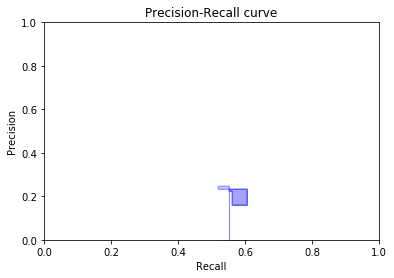

In [38]:

precisionArr = []
recallArr = []
def draw_pr_curve(reg):
    print("lambda",reg)
    print("precision",precisionArr)
    print("recall",recallArr)
    plt.step(recallArr, precisionArr, color='b', alpha=0.2,where='post')
    plt.fill_between(recallArr, precisionArr, step='post', alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.title('Precision-Recall curve')
    
for reg in [1.2,1,4]:
    for i in np.linspace(0,1,10):
        p,r = train_NN(i,reg)
        precisionArr.append(p)
        recallArr.append(r)
    draw_pr_curve(reg)

In [ ]:
for reg in [0.6,0.8]:
    for i in np.linspace(0,1,10):
        p,r = train_NN(i,reg)
        precisionArr.append(p)
        recallArr.append(r)
    draw_pr_curve(reg)

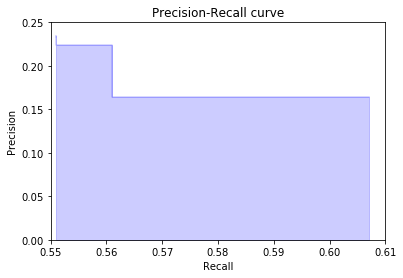

In [58]:
precision = [0.164,0.164,0.224,0.234,0.234,0.233,0.233,0.233,0.233,0.233]
recall = [0.607,0.607,0.561,0.551,0.551,0.551,0.551,0.551,0.551,0.551]
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.25])
plt.xlim([0.55, 0.61])
plt.title('Precision-Recall curve')

In [14]:
# 8/12 find thresh + remove regular on alphas + stochastic + cross entropy logits func + weighted logits+remove min(theta,0) in loss 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN(weight,reg):
    print()
    print("weight: ",weight)
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)
    projector.visualize_embeddings(summary_writer, config)

    tf.reset_default_graph()

    REG_CONST = tf.constant(reg,dtype=tf.float64)
    train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
    dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )

    
    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
    _p_cap = tf.placeholder(tf.float64,shape=(2))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                            dtype=tf.float64)

    #print([n.name for n in tf.get_default_graph().as_graph_def().node])

    #for k = 1

    k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

    k_n1 = tf.negative(k_p1)


    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

    phi_out = tf.stack([phi_p1,phi_n1])
    
    class_weights = tf.constant([weight, 1.0 - weight],dtype=tf.float64)
    
    weighted_logits = tf.multiply(phi_out, class_weights) 

    # loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
    #         tf.reduce_sum(tf.multiply(alphas,alphas)) + \
    #         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
    #         - tf.minimum( tf.reduce_min(thetas),0)
    
    loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_p_cap,logits=weighted_logits))) \
            + (REG_CONST * tf.reduce_sum(tf.multiply(thetas,thetas))) \
            #+tf.reduce_sum(tf.multiply(alphas,alphas)) \
            #- tf.minimum( tf.reduce_min(thetas),0)


    predict = tf.argmax(tf.nn.softmax(weighted_logits))

    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

    new_p_cap = tf.nn.softmax(phi_out)

    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    '''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
            _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            print(_los)
            print(_l)
            print(_s)
            print(_a)
            print(_os)        
            print(_t)
            print()'''

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            total_te+=te_curr
            #print(a)
            #print(t)
            #print
            New_P_cap = []
            newPcap = sess.run(new_p_cap,feed_dict={_x:train_L_S[c+1],_p_cap:train_P_cap[c+1]})
            train_P_cap[c+1] = newPcap
    #         for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
    #             newPcap = sess.run(new_p_cap,feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #             New_P_cap.append(newPcap)
    #         train_P_cap = New_P_cap


            if(abs(te_curr-te_prev)<1e-300):
                break
                predicted_labels = []
                for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                    de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                    predicted_labels.append(p)
                print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels)))


    #         if(c%20==0):
    #             predicted_labels = []
    #             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
    #                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
    #                 predicted_labels.append(p)
    #             print(predicted_labels.count(0),predicted_labels.count(1))
    #             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    #         c+=1
            te_prev = te_curr

        pl = []
        probs = []
        tuned_alphas = []
        for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
            tuned_alphas,te_curr,p,prob = sess.run([alphas,loss,predict,new_p_cap],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
            pl.append(p)
            probs.append(prob)
        probs = np.array(probs)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(tuned_alphas)
        print(predicted_labels.count(1),predicted_labels.count(-1))
        #print("class wise:")
        #print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average=None))
        p,r,f,_ = precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average=None)
        precisionArr.append(p)
        recallArr.append(r)
        #draw_curve(np.array(gold_labels_dev),probs[:,1])
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
        #print('macro',precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        #print('micro',precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='micro'))

    
for reg in [0.5,1,1.5]:
    for i in np.linspace(0,1,10):
        train_NN(i,reg)
        draw_pr_curve(precisionArr,recallArr,reg)


weight:  0.0


/home/vinay/anaconda3/envs/en27/lib/python2.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in double_scalars


0 nan
[ nan  nan  nan  nan  nan  nan  nan]
0 2796
class wise:
(array([ 0.92989986,  0.        ]), array([ 1.,  0.]), array([ 0.9636768,  0.       ]), array([2600,  196]))
(0.0, 0.0, 0.0, None)
('lambda', 0.5)
('precision', [array([ 0.92989986,  0.        ])])
('recall', [array([ 1.,  0.])])


/home/vinay/anaconda3/envs/en27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vinay/anaconda3/envs/en27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


NameError: global name 'recall' is not defined

In [142]:
#stochastic + cross entropy logits func + yi fixed to output of model on discrete lfs
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()

train_P_cap = np.load("Train_P_cap.npy")


#print(train_P_cap)

# discrete_labels = predict_labels(train_P_cap[:1])

# for i in range of discrete_labels:
#     print(train_P_cap[i],discrete_labels[i])

#train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )


dim = 2 #(labels,scores)

_x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(2))

#W =tf.Variable(tf.truncated_normal([len(LFs),len(LFs)], stddev=0.8,dtype = tf.float64))

#b =tf.Variable(tf.truncated_normal([len(LFs)], stddev=0.01,dtype = tf.float64))


alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])

#for k = 1

k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

k_n1 = tf.negative(k_p1)


l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

# phi_out = tf.multiply(l,prelu_out_s)

phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))


# additional_layer_out = tf.matmul(tf.expand_dims(mul_L_S,0),W) + b

# phi_p1 = tf.reduce_sum(tf.multiply(tf.squeeze(additional_layer_out),thetas))

# phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(tf.squeeze(additional_layer_out),k_n1),thetas))

phi_out = tf.stack([phi_p1,phi_n1])


# loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
#         tf.reduce_sum(tf.multiply(alphas,alphas)) + \
#         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
#         - tf.minimum( tf.reduce_min(thetas),0)

loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=phi_out,labels=_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas))\
        + tf.reduce_sum(tf.multiply(thetas,thetas)) 
        #- tf.minimum( tf.reduce_min(thetas),0)\
         

predict = tf.argmax(tf.nn.softmax(phi_out))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
'''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
        _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        print(_los)
        print(_l)
        print(_s)
        print(_a)
        print(_os)        
        print(_t)
        print()'''
    
for i in range(10):
    c = 0
    te_prev=1
    total_te = 0
    for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
        
        a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        total_te+=te_curr
        #print(a)
        #print(t)
        print
        if(abs(te_curr-te_prev)<1e-300):
            predicted_labels = []
            for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                predicted_labels.append(p)
            print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
            break
        
#         if(c%20==0):
#             predicted_labels = []
#             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
#                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
#                 predicted_labels.append(p)
#             print(predicted_labels.count(0),predicted_labels.count(1))
#             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
#         c+=1
        te_prev = te_curr
    pl = []
    print(total_te)
    for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
        te_curr,p = sess.run([loss,predict],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        pl.append(p)
    predicted_labels = [-1 if x==0 else x for x in pl]
    print(predicted_labels.count(1),predicted_labels.count(-1))
    print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
      
    


1.06887941393e+20
515 2281
0   (0.20194174757281552, 0.53061224489795922, 0.29254571026722925, None)
1.31678477484e+29
515 2281
0   (0.20194174757281552, 0.53061224489795922, 0.29254571026722925, None)
1.62112517295e+38
515 2281
0   (0.20194174757281552, 0.53061224489795922, 0.29254571026722925, None)
1.99590613383e+47
515 2281
0   (0.20194174757281552, 0.53061224489795922, 0.29254571026722925, None)
2.45715280858e+56
515 2281
0   (0.20194174757281552, 0.53061224489795922, 0.29254571026722925, None)
3.02509468656e+65
515 2281
0   (0.20194174757281552, 0.53061224489795922, 0.29254571026722925, None)
3.72430034577e+74
515 2281
0   (0.20194174757281552, 0.53061224489795922, 0.29254571026722925, None)


KeyboardInterrupt: 

In [128]:
# Batch with cross entropy logits function  + additional layer
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()


dim = 2 #(labels,scores)

data_size = len(train_L_S_batch[0])

dev_data_size = len(dev_L_S_batch[0])

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )


#train_P_cap = np.full([data_size,2],0.5)

#print(train_P_cap)
#print(train_P_cap.shape)
#dev_P_cap = np.full([dev_data_size,2],0.5)



print(data_size)

_x = tf.placeholder(tf.float64,shape=(dim,None,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(None,2))

W =tf.Variable(tf.truncated_normal([len(LFs),len(LFs)], stddev=0.8,dtype = tf.float64))

b =tf.Variable(tf.truncated_normal([len(LFs)], stddev=0.01,dtype = tf.float64))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.01),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])



l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

additional_layer_out = tf.matmul(mul_L_S,W) + b

phi_p1 = tf.matmul(additional_layer_out,tf.expand_dims(thetas,-1))

phi_n1 = tf.matmul(tf.negative(additional_layer_out),tf.expand_dims(thetas,-1))



# phi_p1 = tf.matmul(mul_L_S,tf.expand_dims(thetas,-1))

# phi_n1 = tf.matmul(tf.negative(mul_L_S),tf.expand_dims(thetas,-1))


phi_out = tf.concat([phi_p1,phi_n1],1)

# pio = tf.Print(phi_out,[phi_out])

# loss = tf.negative(tf.reduce_sum(tf.matmul(tf.transpose(tf.log(tf.nn.softmax(phi_out))),_p_cap))) + \
#         tf.reduce_sum(tf.multiply(alphas,alphas)) +\
#         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
#         - tf.minimum( tf.reduce_min(thetas),0)


loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=phi_out,labels=_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas))\
        - tf.minimum( tf.reduce_min(thetas),0)\
         + tf.reduce_sum(tf.multiply(thetas,thetas)) 
        

predict = tf.argmax(tf.nn.softmax(phi_out),1)

predict_2 = tf.where(tf.greater(tf.slice(tf.nn.softmax(phi_out),[0,1],[dev_data_size,1]),0.5),
                    tf.ones((dev_data_size,1)),tf.negative(tf.ones((dev_data_size,1))))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#print(sess.run([phi_out,predict],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}))

# for i in range(100):
#     _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
#     print(_los)
#     print(_l)
#     print(_s)
#     print(_a)
#     print(_os)        
#     print(_t)
#     print()

for i in range(100):
    c = 0
    te_prev=1
    total_te = 0
    a,t,te_curr,_, = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
    print(te_curr)
    
    train_P_cap = sess.run(new_p_cap,feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}) 
    #print(train_P_cap[0:5])
    #print(a)
    #print(t)
    #print()   
    if(i%1 == 0):
        te_curr,pl,pl2,_ = sess.run([loss,predict,predict_2,train_step],feed_dict={_x:dev_L_S_batch,_p_cap:dev_P_cap})
        pl2 = pl2.flatten().tolist()
        pl = pl.flatten().tolist()
        #print(te_curr)
        #predicted_labels = pl2
        predicted_labels = [-1 if x==0 else 1 for x in pl]
        #for l,l2 in zip(predicted_labels,pl2):
        #    print(l,l2)
        
        print(predicted_labels.count(1),predicted_labels.count(-1))
        #print(predicted_labels,gold_labels_dev)
        print(i," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
 
    if(abs(te_curr-te_prev)<1e-20):
          break
            
  

22195
-0.403062582953
746 2050
0   (0.16085790884718498, 0.61224489795918369, 0.25477707006369427, None)
-0.491641866684
810 1986
1   (0.17037037037037037, 0.70408163265306123, 0.27435387673956263, None)
-0.594699991089
787 2009
2   (0.15374841168996187, 0.61734693877551017, 0.24618514750762968, None)
-0.584680700423
1241 1555
3   (0.11764705882352941, 0.74489795918367352, 0.20320111343075853, None)
-0.629941925989
1247 1549
4   (0.10986367281475541, 0.69897959183673475, 0.18988218988218988, None)
-0.610793114481
899 1897
5   (0.1546162402669633, 0.70918367346938771, 0.25388127853881282, None)
-0.622043836336
820 1976
6   (0.14999999999999999, 0.62755102040816324, 0.24212598425196849, None)
-0.617336477866
1480 1316
7   (0.095270270270270269, 0.71938775510204078, 0.16825775656324585, None)
-0.618130318603
818 1978
8   (0.1687041564792176, 0.70408163265306123, 0.27218934911242604, None)
-0.586582216415
973 1823
9   (0.14285714285714285, 0.70918367346938771, 0.23781009409751927, None)
-0

         Current function value: 330.069609
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 0


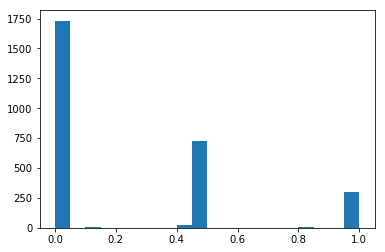

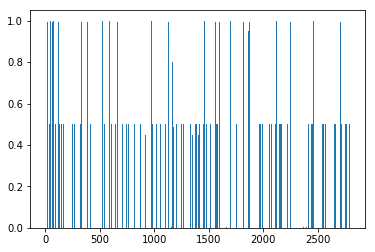

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
Optimization terminated successfully.
         Current function value: 4182.213294
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 1


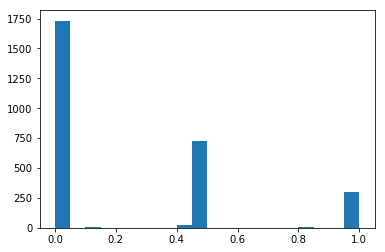

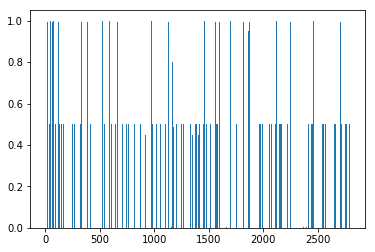

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
test:


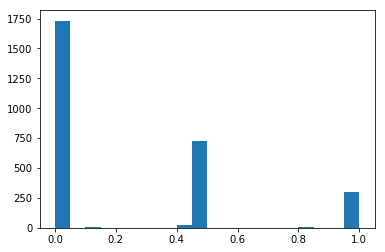

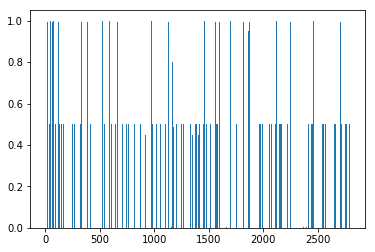

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)


In [11]:
# All LF_Threshold =0.3 and softmax_Threshold=0.3 ,to be run
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

In [ ]:
def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    #plt.bar(range(0,2796),marginals)
    #plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels

#import cPickle as pickle
#THETA = pickle.load( open( "THETA.p", "rb" ) )
#test(THETA)
#LAMDA,SCORE = get_LAMDA(dev_cands)
#Confidence = get_Confidence(LAMDA)

#P_cap = get_P_cap(LAMDA,SCORE,THETA)
#marginals=get_marginals(P_cap)
#plt.hist(marginals, bins=20)
#plt.show()
#plt.bar(range(0,888),train_marginals)
#plt.show()

print_details("dev set",THETA,dev_LAMDA,dev_SCORE)
predicted_labels=predict_labels(marginals)


sorted_predicted_labels=[x for (y,x) in sorted(zip(Confidence,predicted_labels))] #sort Labels as per Confidence
sorted_predicted_labels=list(reversed(sorted_predicted_labels))


for i,j in enumerate(reversed(sorted(zip(Confidence,predicted_labels,gold_labels_dev)))):
    if i>20:
        break
    print i,j
#print(len(marginals),len(predicted_labels),len(gold_labels_dev))
#no_of_labels=186#int(len(predicted_labels)*0.1)  #54 - >0.2  , 108>= 0.15 , 186>= 0.12
#print(len(sorted_predicted_labels[0:no_of_labels]))
no_of_labels=2796
score(predicted_labels[0:no_of_labels],gold_labels_dev[0:no_of_labels])


In [85]:
#stochastic + weighted cross entropy logits func + remove min(theta,0) in loss 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(1),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                break

            if(c%4000==0):
                pl = []
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                predicted_labels = [-1 if x==0 else x for x in pl]
                print()
                print(total_te/4000)
                total_te=0
#                 print(a)
#                 print(t)
#                 print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
train_NN()



-0.000226377142841
2251 545
0  d  (0.58865213829531426, 0.71341836734693875, 0.60408179957052133, None)

-1.94518369934e+28
2232 564
4000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-5.04415736866e+58
2232 564
8000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-1.33431810995e+89
2232 564
12000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-3.67295517678e+119
2232 564
16000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-9.52453175821e+149
2232 564
20000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)
0 -1.71979948062e+170
2232 564
(0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)
